In [2]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")

In [5]:
import os
print(os.getcwd())

/Users/midas-ai/Documents/Personal/agentic-ai-2.0-course/agentic-ai-collections/Assignments/Multi-Agent-Research-Analyst/notebook


In [8]:
#from util.model_loader import ModelLoader

#model_loader = ModelLoader(model_provider="openai")
#llm = model_loader.load_llm()
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm


ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x11ba02790>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x11ba00090>, root_client=<openai.OpenAI object at 0x10a29db90>, root_async_client=<openai.AsyncOpenAI object at 0x11a373410>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [11]:

SYSTEM_ROUTER_PROMPT = """You are a supervisor agent responsible for categorizing user messages into one of the following three categories:
	•	"research_supervisor"
	•	"reporting_supervisor"
	•	"FINISH"

Follow these classification rules strictly:
	1.	Carefully review the entire content of the message.
	2.	If the message refers to tasks such as exploration, investigation, analysis, literature review, or information gathering, categorize it as "research_supervisor".
	3.	If the message refers to tasks like writing, summarizing findings, compiling results, generating reports, or presenting outcomes, categorize it as "reporting_supervisor".
	4.	If the message does not fall under either of the above categories, categorize it as "FINISH".

Respond with only one of the following exact strings, without any additional text or explanation:
	•	research_supervisor
	•	reporting_supervisor
	•	FINISH
"""

In [17]:

from typing import Literal
from typing import Literal, TypedDict

class Router(TypedDict):
    next: Literal['research_supervisor', 'reporting_supervisor', 'FINSIH']  = "FINSIH"


user_message = "Can you analyze recent trends in LLM accuracy across benchmarks?"
messages = [{"role": "system", "content": SYSTEM_ROUTER_PROMPT},] + [{"role": "user", "content": user_message},] 
llm_with_structure_output=llm.with_structured_output(Router)
response=llm_with_structure_output.invoke(messages)
goto=response["next"]
print("**********BELOW IS MY GOTO***************")
print(goto)

**********BELOW IS MY GOTO***************
research_supervisor


In [44]:
from langgraph.graph import MessagesState
from langgraph.graph import MessagesState,StateGraph,END,START
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.types import Command
from IPython.display import Image, display

class AgentState(MessagesState):
    next:str
    
def supervisor_agent(self,state:AgentState)->Command[Literal['research_supervisor', 'reporting_supervisor', '__end__']]:
        messages = [{"role": "system", "content": SYSTEM_ROUTER_PROMPT},] + state["messages"]
        llm_with_structure_output=self.llm.with_structured_output(Router)
        response=llm_with_structure_output.invoke(messages)
        goto=response["next"]
        print("**********BELOW IS MY GOTO***************")
        print(goto)
        if goto == "FINISH":
            goto="__end__"
        return Command(goto=goto, update={"next":goto})
    
def research_supervisor(self,state:AgentState)->Command[Literal['pharma_research', 'financial_research', 'supervisor']]:
    goto=""
    return Command(goto=goto, update={"next":goto})

def pharma_research_agent(state:AgentState)->Command[Literal['research_supervisor']]:

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="research_supervisor",
    )

def financial_research_agent(state:AgentState)->Command[Literal['research_supervisor']]:

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="research_supervisor",
    )


def reporting_supervisor(self,state:AgentState)->Command[Literal['report_creator', 'document_generator', 'supervisor']]:
    goto=""
    return Command(goto=goto, update={"next":goto})


def report_creator_agent(state:AgentState)->Command[Literal['reporting_supervisor']]:

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="reporting_supervisor",
    )

def document_generator_agent(state:AgentState)->Command[Literal['reporting_supervisor']]:

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="reporting_supervisor",
    )



    
    

In [45]:
from langgraph.graph import START
a2a_graph = StateGraph(AgentState)

a2a_graph.add_node("supervisor",supervisor_agent)
a2a_graph.add_node("research_supervisor",research_supervisor)
a2a_graph.add_node("pharma_research",pharma_research_agent)
a2a_graph.add_node("financial_research",financial_research_agent)

a2a_graph.add_node("reporting_supervisor",reporting_supervisor)
a2a_graph.add_node("report_creator",report_creator_agent)
a2a_graph.add_node("document_generator",document_generator_agent)

a2a_graph.set_entry_point("supervisor")

print(a2a_graph.edges) 

a2a_app=a2a_graph.compile()



{('__start__', 'supervisor')}


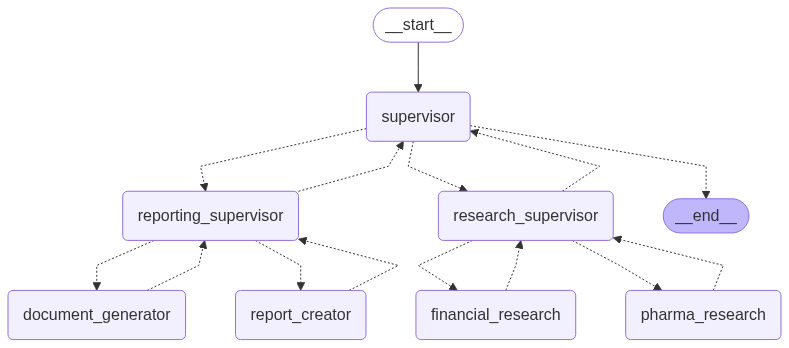

In [46]:
display(Image(a2a_app.get_graph(xray=True).draw_mermaid_png()))